<div style="text-align: center; font-size: 16px;">
    <strong>Course:</strong> Machine Learning Operations |
    <strong>Lecturer:</strong> Prof. Dr. Klotz |
    <strong>Date:</strong> 17.05.2025 |
    <strong>Name:</strong> Sofie Pischl
</div>

# <center>Preprocessing</center>

# Struktur des Notebooks

## 1. Setup und Bibliotheken

In diesem Abschnitt werden alle benötigten Bibliotheken importiert und notwendige NLP-Ressourcen geladen (z. B. NLTK-Modelle).

In [ ]:
import os
import pandas as pd
#pd.set_option('display.max_colwidth', None)
pd.reset_option('display.max_colwidth')
pd.set_option('display.max_columns', None)
import numpy as np
import re
from pathlib import Path
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from textblob import TextBlob
import logging
import sqlite3

# Logging Setup
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# NLTK-Ressourcen laden
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to /Users/sofl3/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/sofl3/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sofl3/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sofl3/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## 2. Daten laden

Hier werden die Rohdaten aus TikTok, YouTube und Reddit eingelesen.


In [ ]:
BASE_DIR = Path().resolve().parent
RAW_DIR = (BASE_DIR / "./data").resolve()

# DB-Pfad
DB_PATH = Path(BASE_DIR / "data/social_media.db")

# Verbindung öffnen
conn = sqlite3.connect(DB_PATH)

# Lese jede Tabelle einzeln
df_reddit = pd.read_sql_query("SELECT * FROM reddit_data", conn)
df_tiktok = pd.read_sql_query("SELECT * FROM tiktok_data", conn)
df_youtube = pd.read_sql_query("SELECT * FROM youtube_data", conn)

conn.close()

dfs = {
    "Reddit": df_reddit,
    "TikTok": df_tiktok,
    "YouTube": df_youtube
}

for name, df in dfs.items():
    print(f"\n📊 === {name} Data ===")
    print("🔹 Kopf der Tabelle:")
    print(display(df.head()), "\n")
    
    print("🔹 Info:")
    df.info()
    print("\n" + "-"*50)


📊 === Reddit Data ===
🔹 Kopf der Tabelle:


,id,title,author,score,created_utc,num_comments,url,subreddit,scraped_at
0,8be61f8d1c51cc3455edab639cba425e,She erased us from her wedding. So I’m erasing...,,4545,1746242393,1044,https://www.reddit.com/r/pettyrevenge/comments...,all,2025-05-03 08:58:16
1,3b1b90fc5a5bd6a0f94520a092025594,UPDATE: AITAH for telling my MIL to stop calli...,,4137,1746229105,247,https://www.reddit.com/r/AITAH/comments/1kdhk8...,all,2025-05-03 08:58:16
2,c0c900e9ade80cb4f515058aa9d46935,"Conservatives, if you cared about Hunter Biden...",,3600,1746228869,777,https://www.reddit.com/r/AskUS/comments/1kdhhk...,all,2025-05-03 08:58:16
3,2b85537cf40b516ef32e14dd2ab51bcd,What’s a subtle sign that someone has been thr...,,3355,1746230270,1469,https://www.reddit.com/r/AskReddit/comments/1k...,all,2025-05-03 08:58:16
4,3425bee6d1a5174eeb5c57e3537e5ad9,TIFU by trying to flirt with a guy at the gym ...,,2138,1746237908,174,https://www.reddit.com/r/tifu/comments/1kdk6o7...,all,2025-05-03 08:58:16


None 

🔹 Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            705 non-null    object
 1   title         705 non-null    object
 2   author        705 non-null    object
 3   score         705 non-null    int64 
 4   created_utc   705 non-null    int64 
 5   num_comments  705 non-null    int64 
 6   url           705 non-null    object
 7   subreddit     705 non-null    object
 8   scraped_at    705 non-null    object
dtypes: int64(3), object(6)
memory usage: 49.7+ KB

--------------------------------------------------

📊 === TikTok Data ===
🔹 Kopf der Tabelle:


,id,description,author_username,author_id,likes,shares,comments,plays,video_url,created_time,scraped_at
0,7493469801654881542,#vairalvideo_foryoupage #🇦🇫ازبک_تاجک_پشتون_تر...,afgcap.cut,7461541069958153234,15800,451,258,365200,https://webapp-va.tiktok.com/88847b04ddf03213d...,1744709406,2025-05-11 15:19:41
1,7489427780397010198,#imapoliceofficer #tensheet #foryou #viral #fy...,backwheelbandit69,7416366442453632032,4400000,308300,11800,43200000,https://v16-webapp-prime.tiktok.com/video/tos/...,1743768297,2025-05-11 15:19:41
2,7492000423641959685,#CapCut #قوالب_كاب_كات_جاهزه_للتصميم__🌴♥ #كاب_...,noordeen_cap_cat_0_1,7322835376556442629,58400,1576,451,1300000,https://webapp-va.tiktok.com/6508d64d970e751a2...,1744367290,2025-05-11 15:19:41
3,7472584144510373125,i think it was a bad idea,maligoshik,7014608336423617542,19000000,1300000,26500,186100000,https://v16-webapp-prime.tiktok.com/video/tos/...,1739846584,2025-05-11 15:19:42
4,7461927005689302280,welcome to the thanos world!! #squidgame #squi...,team_thanos_player230,7455509281098515474,261400,9526,13000,12400000,https://webapp-sg.tiktok.com/bf63b8aa40b9ff0ca...,1737365272,2025-05-11 15:06:10


None 

🔹 Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1406 entries, 0 to 1405
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               1406 non-null   object
 1   description      1403 non-null   object
 2   author_username  1406 non-null   object
 3   author_id        1406 non-null   object
 4   likes            1406 non-null   int64 
 5   shares           1406 non-null   int64 
 6   comments         1406 non-null   int64 
 7   plays            1406 non-null   int64 
 8   video_url        1396 non-null   object
 9   created_time     1406 non-null   int64 
 10  scraped_at       1406 non-null   object
dtypes: int64(5), object(6)
memory usage: 121.0+ KB

--------------------------------------------------

📊 === YouTube Data ===
🔹 Kopf der Tabelle:


,video_id,title,channel_title,view_count,like_count,comment_count,published_at,scraped_at
0,-F33ACcPbhU,Monster Hunter Wilds – Festival of Accord: Blo...,Monster Hunter,195940,9298,619,2025-04-22 01:00:25,2025-04-22 22:06:12
1,-H8tvnWaYs4,Chelsea 3-1 Liverpool | HIGHLIGHTS | Premier L...,Chelsea Football Club,1333458,28389,780,2025-05-04 21:00:09,2025-05-05 18:10:08
2,-JFW5V4U6bo,Picks 1-10: Jaguars TRADE UP For Travis Hunter...,NFL,443795,8052,1112,2025-04-25 01:55:00,2025-04-25 14:45:45
3,-K8jSo03dEk,"planes if they were 10,000 times better",Ice Cream Sandwich,863723,81195,4095,2025-05-03 02:01:54,2025-05-04 09:00:05
4,-QwXokuIZjM,Peacemaker Season 2 | Official Teaser | Max,Max,1829543,96169,6397,2025-05-09 16:05:08,2025-05-10 13:41:28


None 

🔹 Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   video_id       350 non-null    object
 1   title          350 non-null    object
 2   channel_title  350 non-null    object
 3   view_count     350 non-null    int64 
 4   like_count     350 non-null    int64 
 5   comment_count  350 non-null    int64 
 6   published_at   350 non-null    object
 7   scraped_at     350 non-null    object
dtypes: int64(3), object(5)
memory usage: 22.0+ KB

--------------------------------------------------


## 3. Textbereinigung und Feature-Extraktion

Hier definieren wir Funktionen zur Reinigung, Lemmatization, Stopwortfilterung und Extraktion von Textmerkmalen für Sentimentanalyse und Topic Modeling.


In [5]:
def remove_emojis(text):
    if not isinstance(text, str):
        return ""
    emoji_pattern = re.compile(
        "[" 
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        u"\U00002700-\U000027BF"
        u"\U000024C2-\U0001F251"
        "]", flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'): return wordnet.ADJ
    elif treebank_tag.startswith('V'): return wordnet.VERB
    elif treebank_tag.startswith('N'): return wordnet.NOUN
    elif treebank_tag.startswith('R'): return wordnet.ADV
    return wordnet.NOUN

def lemmatize_tokens(tokens):
    tagged = pos_tag(tokens)
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w, get_wordnet_pos(t)) for w, t in tagged]

def preprocess_text(text, remove_stopwords=True):
    if not isinstance(text, str):
        return ""

    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = remove_emojis(text)
    text = re.sub(r'#(\w+)', r'\1', text)
    text = re.sub(r'[^\w\s\']', ' ', text)
    text = re.sub(r'\s\'|\'\s', ' ', text)
    text = ' '.join(text.split())

    tokens = word_tokenize(text)

    if remove_stopwords:
        stop_words = set()
        for lang in ['english', 'german']:
            try:
                stop_words.update(stopwords.words(lang))
            except:
                logger.warning(f"Stopwords for {lang} not available")
        important_words = {"n't", "'s", "'m", "'re", "'ve", "'ll", "no", "not"}
        stop_words -= important_words
        tokens = [token for token in tokens if token.lower() not in stop_words]

    return ' '.join(lemmatize_tokens(tokens))

def extract_text_features(text):
    if not isinstance(text, str) or not text.strip():
        return {
            'word_count': 0,
            'char_count': 0,
            'avg_word_length': 0,
            'sentiment_polarity': 0,
            'sentiment_subjectivity': 0
        }
    words = text.split()
    blob = TextBlob(text)
    return {
        'word_count': len(words),
        'char_count': len(text),
        'avg_word_length': len(text) / len(words),
        'sentiment_polarity': blob.sentiment.polarity,
        'sentiment_subjectivity': blob.sentiment.subjectivity
    }

def apply_text_processing(df, col):
    df = df.copy()
    df[f"{col}_processed"] = df[col].astype(str).apply(preprocess_text)
    features = df[f"{col}_processed"].apply(extract_text_features)
    return pd.concat([df, pd.DataFrame(features.tolist())], axis=1)


## 4. Plattformdaten bereinigen

Die Inhalte der Plattformen unterscheiden sich strukturell, daher erfolgt die Bereinigung pro Quelle individuell.


## Reddit

In [6]:
def clean_reddit_data(path: Path) -> pd.DataFrame:
   
    # Sicherstellen, dass Datumsspalten korrekt sind
    for date_col in ['created', 'scraped_at']:
        if date_col in df.columns:
            df[date_col] = pd.to_datetime(df[date_col], errors='coerce')

    # Nur relevante Spalten behalten
    relevant_columns = ['subreddit', 'title', 'text', 'score', 'comments', 'created', 'url', 'scraped_at']
    existing_columns = [col for col in relevant_columns if col in df.columns]
    df = df[existing_columns].copy()

    # NaNs entfernen (essentielle Felder)
    df = df.dropna(subset=['text'])

    # Duplikate entfernen
    df = df.drop_duplicates(subset=['text'])

    # Fehlende scraped_at-Werte durch created ersetzen
    df['scraped_at'] = df.get('scraped_at', pd.NaT).fillna(df.get('created'))


    return df

df_reddit = clean_reddit_data(df_reddit)

print("\nErste 5 Zeilen der bereinigten Reddit-Daten:")
display(df_reddit.head())

print("\nInformationen über den Datensatz:")
print(df_reddit.info())


ERROR:__main__:Fehler beim Einlesen der Reddit-Daten: [Errno 2] No such file or directory: '/Users/sofl3/Documents/TrendAnalyseSocialMedia/data/raw/reddit_data.csv'



Erste 5 Zeilen der bereinigten Reddit-Daten:


""



Informationen über den Datensatz:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Empty DataFrame
None


In [158]:
# Wenn die Spalte 'created' als datetime formatiert ist:
df_reddit["created"] = pd.to_datetime(df_reddit["created"], errors="coerce")

# Nur das Datum extrahieren
df_reddit["date"] = df_reddit["created"].dt.date

# Gruppieren und zählen
date_counts = df_reddit["date"].value_counts().sort_index()

# Ausgabe
for d, count in date_counts.items():
    print(f"{d}: {count} Einträge")

2021-03-07: 2 Einträge
2021-03-08: 2 Einträge
2021-03-09: 2 Einträge
2021-03-11: 2 Einträge
2021-03-12: 2 Einträge
2021-03-13: 2 Einträge
2021-03-15: 2 Einträge
2021-03-16: 2 Einträge
2021-03-17: 2 Einträge
2021-03-18: 2 Einträge
2021-03-19: 2 Einträge
2021-03-20: 2 Einträge
2021-03-21: 2 Einträge
2021-03-22: 2 Einträge
2021-03-23: 2 Einträge
2021-03-24: 2 Einträge
2021-03-25: 2 Einträge
2021-03-26: 2 Einträge
2021-03-27: 2 Einträge
2021-03-28: 2 Einträge
2021-03-29: 2 Einträge
2021-03-30: 2 Einträge
2021-03-31: 2 Einträge
2021-04-01: 2 Einträge
2021-04-02: 2 Einträge
2021-04-03: 2 Einträge
2021-04-04: 2 Einträge
2021-04-05: 4 Einträge
2021-04-06: 2 Einträge
2021-04-07: 2 Einträge
2021-04-08: 2 Einträge
2021-04-09: 2 Einträge
2021-04-10: 2 Einträge
2021-04-11: 2 Einträge
2021-04-12: 2 Einträge
2021-04-13: 2 Einträge
2021-04-14: 2 Einträge
2021-04-15: 2 Einträge
2021-04-16: 2 Einträge
2021-04-17: 2 Einträge
2021-04-18: 2 Einträge
2021-04-19: 2 Einträge
2021-04-20: 2 Einträge
2021-04-21:

In [159]:
# Stelle sicher, dass 'created' als datetime erkannt ist
df_reddit["created"] = pd.to_datetime(df_reddit["created"], errors="coerce")

# Filter: Nur Zeilen behalten, deren Jahr ungleich 2021 ist
df_reddit = df_reddit[df_reddit["created"].dt.year != 2021]

In [160]:
# Wenn die Spalte 'created' als datetime formatiert ist:
df_reddit["created"] = pd.to_datetime(df_reddit["created"], errors="coerce")

# Nur das Datum extrahieren
df_reddit["date"] = df_reddit["created"].dt.date

# Gruppieren und zählen
date_counts = df_reddit["date"].value_counts().sort_index()

# Ausgabe
for d, count in date_counts.items():
    print(f"{d}: {count} Einträge")

2025-03-08: 1 Einträge
2025-03-13: 1 Einträge
2025-03-15: 1 Einträge
2025-03-23: 1 Einträge
2025-03-24: 1 Einträge
2025-03-26: 1 Einträge
2025-03-28: 2 Einträge
2025-04-02: 3 Einträge
2025-04-10: 1 Einträge
2025-04-11: 1 Einträge
2025-04-12: 1 Einträge
2025-04-14: 16 Einträge
2025-04-15: 9 Einträge
2025-04-18: 5 Einträge
2025-04-19: 6 Einträge
2025-04-20: 1 Einträge
2025-04-21: 1 Einträge
2025-04-22: 7 Einträge
2025-04-23: 14 Einträge
2025-04-24: 13 Einträge
2025-04-25: 10 Einträge
2025-04-28: 1 Einträge
2025-04-30: 1 Einträge
2025-05-01: 9 Einträge
2025-05-02: 19 Einträge
2025-05-03: 39 Einträge
2025-05-04: 32 Einträge
2025-05-05: 41 Einträge
2025-05-06: 28 Einträge
2025-05-07: 34 Einträge
2025-05-08: 17 Einträge
2025-05-09: 13 Einträge


In [161]:
# Sortiere nach dem kombinierten datetime-Wert (älteste zuerst)
df_sorted = df_reddit.sort_values("created", ascending=True).reset_index(drop=True)

df_sorted

,subreddit,title,text,score,comments,created,url,scraped_at,date
0,trendingreddits,My New Website,ShopSphere is my new website I have just creat...,0,0,2025-03-08 05:10:26,https://www.reddit.com/r/TrendingReddits/comme...,2025-04-14 20:31:29.692066,2025-03-08
1,trendingreddits,Calling Out: Tabloid Writers,I am doing a story around Torontonians' perspe...,2,0,2025-03-13 04:08:46,https://www.reddit.com/r/TrendingReddits/comme...,2025-04-14 20:31:29.692066,2025-03-13
2,trendingreddits,Suicidal 1,"Dear Friend,\n\nMy name is Denzo, and I write ...",3,4,2025-03-15 01:24:47,https://www.reddit.com/r/TrendingReddits/comme...,2025-04-14 20:31:29.692066,2025-03-15
3,trendingreddits,Year by year,2017:swag\n\n2018:thug life\n\n2019:savage\n\n...,3,0,2025-03-23 11:12:54,https://www.reddit.com/r/TrendingReddits/comme...,2025-04-14 20:31:29.692066,2025-03-23
4,trendingreddits,Binance,Únete a la competencia por ROI de Spot en Bina...,1,0,2025-03-24 07:26:14,https://www.reddit.com/r/TrendingReddits/comme...,2025-04-14 20:31:29.692066,2025-03-24
...,...,...,...,...,...,...,...,...,...
325,popular,AITAH for telling my coworker to stop eating m...,"I’m 30M, and I work in a small office with lik...",2047,581,2025-05-09 06:38:17,https://www.reddit.com/r/AITAH/comments/1kibzn...,2025-05-09 11:29:51.719281,2025-05-09
326,popular,How Sandfall Interactive artificially inflated...,\nOver the last week and a half you have proba...,1090,129,2025-05-09 08:49:13,https://www.reddit.com/r/expedition33/comments...,2025-05-09 11:29:51.719281,2025-05-09
327,popular,One Piece: Chapter 1148,"# Chapter 1148: ""RONJA""\n\n|Source|Status|\n|:...",805,432,2025-05-09 09:26:50,https://www.reddit.com/r/OnePiece/comments/1ki...,2025-05-09 13:56:35.184927,2025-05-09
328,all,My coworker kept calling me his ‘work wife’......,"So, my coworker John from HR starts saying thi...",1917,236,2025-05-09 11:35:16,https://www.reddit.com/r/coworkerstories/comme...,2025-05-09 15:09:04.723035,2025-05-09


## TikTok

In [162]:
def clean_tiktok_data(path: Path) -> pd.DataFrame:
    """
    Lädt und bereinigt TikTok-Daten aus einer CSV-Datei.
    Wandelt numerische Spalten in Integer und Timestamp in datetime.
    """
    try:
        df = pd.read_csv(path)
    except Exception as e:
        logger.error(f"Fehler beim Einlesen der TikTok-Daten: {e}")
        return pd.DataFrame()

    # Relevante Spalten selektieren
    relevant_columns = [
        'id', 'description', 'author_username', 'author_id',
        'likes', 'shares', 'comments', 'plays', 'video_url', 'created_time'
    ]
    existing_columns = [col for col in relevant_columns if col in df.columns]
    df = df[existing_columns].copy()

    # Spalten umbenennen
    df = df.rename(columns={
        'author_username': 'username',
        'author_id': 'user_id',
        'created_time': 'timestamp'
    })

    # Numerische Spalten konvertieren: NaN → 0, dann int
    numeric_cols = ['likes', 'shares', 'comments', 'plays']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

    # Zeitstempel als datetime konvertieren
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', errors='coerce')

    # Leere oder fehlende Beschreibungen entfernen
    df['description'] = df['description'].fillna("").astype(str)
    df = df[df['description'].str.strip() != ""]

    # Doppelte Beschreibungen entfernen (behalte erste Vorkommen)
    df = df.drop_duplicates(subset=['description'])

    return df


df_tiktok = clean_tiktok_data(data_paths["tiktok"])

print("\nErste 5 Zeilen:")
display(df_tiktok.head())


print("Dataframe Info:")
print(df_tiktok.info())


Erste 5 Zeilen:


C:\Users\SofiePischl\AppData\Local\Temp\ipykernel_9844\3186445448.py:34: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s', errors='coerce')


,id,description,username,user_id,likes,shares,comments,plays,video_url,timestamp
0,7493469801654881542,#vairalvideo_foryoupage #🇦🇫ازبک_تاجک_پشتون_تر...,afgcap.cut,7461541069958153234,15800,451,258,365200,https://v16-webapp-prime.tiktok.com/video/tos/...,2025-04-15 09:30:06
1,7489427780397010198,#imapoliceofficer #tensheet #foryou #viral #fy...,backwheelbandit69,7416366442453632032,4300000,303800,11300,41900000,https://v16-webapp-prime.tiktok.com/video/tos/...,2025-04-04 12:04:57
2,7492000423641959685,#CapCut #قوالب_كاب_كات_جاهزه_للتصميم__🌴♥ #كاب_...,noordeen_cap_cat_0_1,7322835376556442629,58400,1576,451,1300000,https://v16-webapp-prime.tiktok.com/video/tos/...,2025-04-11 10:28:10
3,7472584144510373125,i think it was a bad idea,maligoshik,7014608336423617542,18000000,1300000,24000,168600000,https://v16-webapp-prime.tiktok.com/video/tos/...,2025-02-18 02:43:04
4,7461927005689302280,welcome to the thanos world!! #squidgame #squi...,team_thanos_player230,7455509281098515474,261400,9526,13000,12400000,https://webapp-sg.tiktok.com/bf63b8aa40b9ff0ca...,2025-01-20 09:27:52


Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1082 entries, 0 to 6508
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   id           1082 non-null   object        
 1   description  1082 non-null   object        
 2   username     1082 non-null   object        
 3   user_id      1082 non-null   object        
 4   likes        1082 non-null   int32         
 5   shares       1082 non-null   int32         
 6   comments     1082 non-null   int32         
 7   plays        1082 non-null   int32         
 8   video_url    658 non-null    object        
 9   timestamp    1081 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int32(4), object(5)
memory usage: 76.1+ KB
None


In [163]:
# Wenn die Spalte 'created' als datetime formatiert ist:
df_tiktok["created"] = pd.to_datetime(df_tiktok["timestamp"], errors="coerce")

# Nur das Datum extrahieren
df_tiktok["date"] = df_tiktok["created"].dt.date

# Gruppieren und zählen
date_counts = df_tiktok["date"].value_counts().sort_index()

# Ausgabe
for d, count in date_counts.items():
    print(f"{d}: {count} Einträge")

2024-08-11: 1 Einträge
2024-08-27: 2 Einträge
2024-09-18: 1 Einträge
2024-10-05: 1 Einträge
2025-01-07: 1 Einträge
2025-01-19: 1 Einträge
2025-01-20: 1 Einträge
2025-01-21: 3 Einträge
2025-01-27: 2 Einträge
2025-01-31: 1 Einträge
2025-02-03: 1 Einträge
2025-02-04: 2 Einträge
2025-02-05: 4 Einträge
2025-02-06: 3 Einträge
2025-02-08: 8 Einträge
2025-02-09: 5 Einträge
2025-02-10: 4 Einträge
2025-02-11: 4 Einträge
2025-02-12: 3 Einträge
2025-02-13: 8 Einträge
2025-02-14: 7 Einträge
2025-02-15: 6 Einträge
2025-02-16: 5 Einträge
2025-02-17: 5 Einträge
2025-02-18: 8 Einträge
2025-02-19: 3 Einträge
2025-02-20: 8 Einträge
2025-02-21: 9 Einträge
2025-02-22: 11 Einträge
2025-02-23: 3 Einträge
2025-02-24: 6 Einträge
2025-02-25: 6 Einträge
2025-02-26: 10 Einträge
2025-02-27: 10 Einträge
2025-02-28: 9 Einträge
2025-03-01: 9 Einträge
2025-03-02: 7 Einträge
2025-03-03: 14 Einträge
2025-03-04: 7 Einträge
2025-03-05: 14 Einträge
2025-03-06: 5 Einträge
2025-03-07: 7 Einträge
2025-03-08: 3 Einträge
2025-0

# YouTube

In [164]:
def clean_youtube_data(df):
    df = df.copy()

    # Textfelder bereinigen
    for col in ['title', 'description']:
        df[col] = df[col].fillna('')

    # Timestamps umwandeln
    for col in ['trending_date', 'scraped_at', 'published_at']:
        df[col] = pd.to_datetime(df[col], errors='coerce')

    # Counts in ganze Zahlen konvertieren (mit NaN als -1 oder 0, je nach Bedarf)
    for col in ['view_count', 'like_count', 'comment_count']:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

    # Leere oder fehlende Beschreibungen entfernen
    df['description'] = df['description'].astype(str).str.strip()
    df = df[df['description'] != ""]

    # Doppelte Beschreibungen entfernen
    df = df.drop_duplicates(subset=['description'])

    return df

# Anwenden
df_youtube = clean_youtube_data(data['youtube'])

# Anzeige
display(df_youtube.head())
df_youtube.info()


,video_id,title,description,channel_title,published_at,view_count,like_count,comment_count,url,scraped_at,trending_date
0,-F33ACcPbhU,Monster Hunter Wilds – Festival of Accord: Blo...,Bask in the springtime aura and enjoy cherry b...,Monster Hunter,2025-04-22 01:00:25+00:00,195940,9298,619,https://www.youtube.com/watch?v=-F33ACcPbhU,2025-04-22 22:06:12.302112,NaT
1,-H8tvnWaYs4,Chelsea 3-1 Liverpool | HIGHLIGHTS | Premier L...,PL Matchday 35 - Highlights of Chelsea's 3-1 P...,Chelsea Football Club,2025-05-04 21:00:09+00:00,1684539,31221,878,https://www.youtube.com/watch?v=-H8tvnWaYs4,NaT,2025-05-07
5,-JFW5V4U6bo,Picks 1-10: Jaguars TRADE UP For Travis Hunter...,"Watch live local and primetime games, NFL RedZ...",NFL,2025-04-25 01:55:00+00:00,443795,8052,1112,https://www.youtube.com/watch?v=-JFW5V4U6bo,2025-04-25 14:45:45.902741,NaT
6,-K8jSo03dEk,"planes if they were 10,000 times better",Get NordVPN’s 2 year plan + 4 extra months fre...,Ice Cream Sandwich,2025-05-03 02:01:54+00:00,863723,81195,4095,https://www.youtube.com/watch?v=-K8jSo03dEk,NaT,2025-05-04
8,-Kdh5T_feIg,AZET x BOBBY VANDAMME - BUSCAPE (Official Video),PLAYBOYS IM AMG ERSCHEINT AM 19.09.2025\nLimit...,KMNGANG,2025-05-08 21:59:19+00:00,105023,12217,880,https://www.youtube.com/watch?v=-Kdh5T_feIg,NaT,2025-05-09


<class 'pandas.core.frame.DataFrame'>
Index: 316 entries, 0 to 537
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   video_id       316 non-null    object             
 1   title          316 non-null    object             
 2   description    316 non-null    object             
 3   channel_title  316 non-null    object             
 4   published_at   315 non-null    datetime64[ns, UTC]
 5   view_count     316 non-null    int32              
 6   like_count     316 non-null    int32              
 7   comment_count  316 non-null    int32              
 8   url            316 non-null    object             
 9   scraped_at     149 non-null    datetime64[ns]     
 10  trending_date  166 non-null    datetime64[ns]     
dtypes: datetime64[ns, UTC](1), datetime64[ns](2), int32(3), object(5)
memory usage: 25.9+ KB


In [165]:
# Wenn die Spalte 'created' als datetime formatiert ist:
df_youtube["created"] = pd.to_datetime(df_youtube["published_at"], errors="coerce")

# Nur das Datum extrahieren
df_youtube["date"] = df_youtube["created"].dt.date

# Gruppieren und zählen
date_counts = df_youtube["date"].value_counts().sort_index()

# Ausgabe
for d, count in date_counts.items():
    print(f"{d}: {count} Einträge")

2025-04-16: 1 Einträge
2025-04-17: 4 Einträge
2025-04-18: 7 Einträge
2025-04-19: 8 Einträge
2025-04-20: 10 Einträge
2025-04-21: 16 Einträge
2025-04-22: 26 Einträge
2025-04-23: 14 Einträge
2025-04-24: 14 Einträge
2025-04-25: 2 Einträge
2025-04-27: 2 Einträge
2025-04-28: 6 Einträge
2025-04-29: 16 Einträge
2025-04-30: 15 Einträge
2025-05-01: 28 Einträge
2025-05-02: 20 Einträge
2025-05-03: 23 Einträge
2025-05-04: 18 Einträge
2025-05-05: 11 Einträge
2025-05-06: 23 Einträge
2025-05-07: 13 Einträge
2025-05-08: 33 Einträge
2025-05-09: 5 Einträge


# 5. Zusammenführen der Daten

In [166]:
# Extrahiert die ID aus einer URL (der Teil nach dem letzten Slash)
def extract_id_from_url(url):
    if isinstance(url, str):
        return url.rstrip('/').split('/')[-1]
    return None

In [167]:
# Diese Funktion vereinheitlicht die Struktur der drei Plattformen in ein einheitliches Format
def unify_dataframes(df_tiktok, df_youtube, df_reddit):
    # TikTok
    df_tiktok_clean = pd.DataFrame({
        'source': 'tiktok',
        'id': df_tiktok['id'],
        'title': None,
        'text': df_tiktok['description'],
        'username': df_tiktok['username'],
        'likes': df_tiktok['likes'],
        'comments': df_tiktok['comments'],
        'shares': df_tiktok['shares'],
        'plays': df_tiktok['plays'],
        'timestamp': df_tiktok['timestamp'],
        'published_at': None,
        'url': df_tiktok['video_url']
    })

    # YouTube
    df_youtube_clean = pd.DataFrame({
        'source': 'youtube',
        'id': df_youtube['video_id'],
        'title': df_youtube['title'],
        'text': df_youtube['description'],
        'username': df_youtube['channel_title'],
        'likes': df_youtube['like_count'],
        'comments': df_youtube['comment_count'],
        'shares': None,
        'plays': df_youtube['view_count'],
        'timestamp': df_youtube['scraped_at'],
        'published_at': df_youtube['published_at'],
        'url': df_youtube['url']
    })

    # Reddit
    df_reddit_clean = pd.DataFrame({
        'source': 'reddit',
        'id': df_reddit['url'].apply(extract_id_from_url),
        'title': df_reddit['title'],
        'text': df_reddit['text'],
        'username': None,
        'likes': df_reddit['score'],
        'comments': df_reddit['comments'],
        'shares': None,
        'plays': None,
        'timestamp': df_reddit['scraped_at'],
        'published_at': df_reddit['created'],
        'url': df_reddit['url']
    })

    # Kombinieren aller Plattformen in einem DataFrame
    return pd.concat([df_tiktok_clean, df_youtube_clean, df_reddit_clean], ignore_index=True)

# Zusammenführen der Plattform-Daten
df_combined = unify_dataframes(df_tiktok, df_youtube, df_reddit)
df_combined.head()


,source,id,title,text,username,likes,comments,shares,plays,timestamp,published_at,url
0,tiktok,7493469801654881542,None,#vairalvideo_foryoupage #🇦🇫ازبک_تاجک_پشتون_تر...,afgcap.cut,15800,258,451,365200,2025-04-15 09:30:06,None,https://v16-webapp-prime.tiktok.com/video/tos/...
1,tiktok,7489427780397010198,None,#imapoliceofficer #tensheet #foryou #viral #fy...,backwheelbandit69,4300000,11300,303800,41900000,2025-04-04 12:04:57,None,https://v16-webapp-prime.tiktok.com/video/tos/...
2,tiktok,7492000423641959685,None,#CapCut #قوالب_كاب_كات_جاهزه_للتصميم__🌴♥ #كاب_...,noordeen_cap_cat_0_1,58400,451,1576,1300000,2025-04-11 10:28:10,None,https://v16-webapp-prime.tiktok.com/video/tos/...
3,tiktok,7472584144510373125,None,i think it was a bad idea,maligoshik,18000000,24000,1300000,168600000,2025-02-18 02:43:04,None,https://v16-webapp-prime.tiktok.com/video/tos/...
4,tiktok,7461927005689302280,None,welcome to the thanos world!! #squidgame #squi...,team_thanos_player230,261400,13000,9526,12400000,2025-01-20 09:27:52,None,https://webapp-sg.tiktok.com/bf63b8aa40b9ff0ca...


In [168]:
# Anzahl der Posts pro Plattform
post_counts = df_combined["source"].value_counts().reset_index()
post_counts.columns = ["source", "num_posts"]

# Anzeige
print(post_counts)

    source  num_posts
0   tiktok       1082
1   reddit        330
2  youtube        316


C:\Users\SofiePischl\AppData\Local\Temp\ipykernel_9844\1435785843.py:29: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\SofiePischl\Documents\01_HdM\10_ML_OPS\TrendAnalyseSocialMedia\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


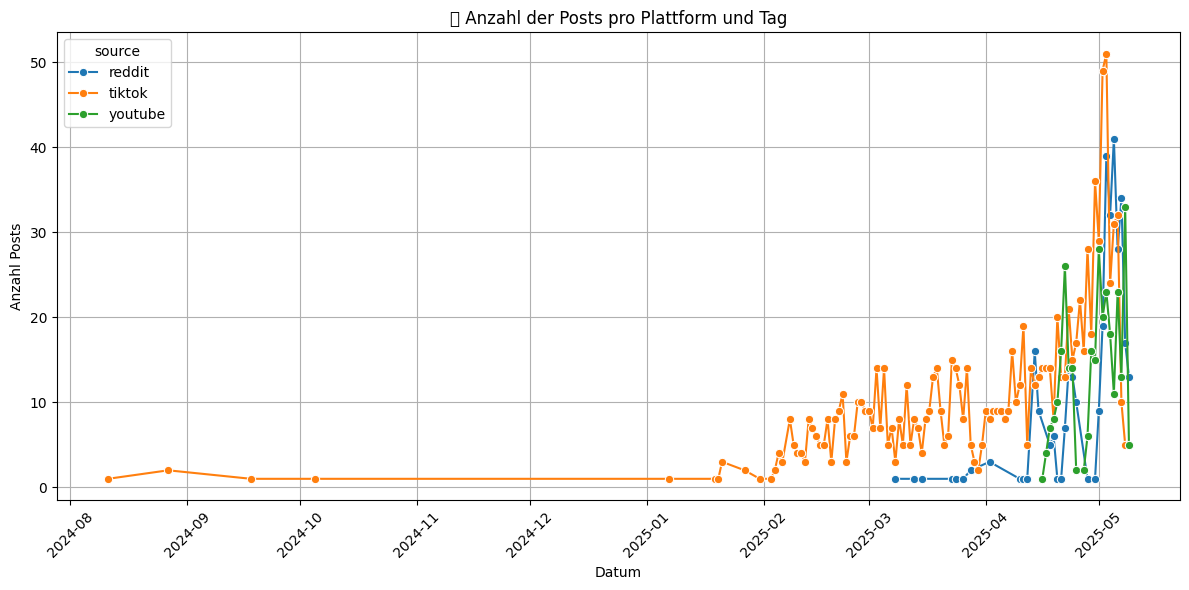

In [169]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Beide Spalten sicher in datetime umwandeln
df_combined["published_at"] = pd.to_datetime(df_combined.get("published_at"), errors="coerce", utc=True)
df_combined["timestamp"] = pd.to_datetime(df_combined.get("timestamp"), errors="coerce", utc=True)

# Zeilenweise Auswahl: published_at, falls vorhanden – sonst timestamp
df_combined["datetime"] = df_combined.apply(
    lambda row: row["published_at"] if pd.notna(row["published_at"]) else row["timestamp"],
    axis=1
)

# Nur Datum extrahieren
df_combined["date"] = df_combined["datetime"].dt.date

# Anzahl der Posts pro Plattform pro Tag
posts_per_day = df_combined.groupby(["source", "date"]).size().reset_index(name="post_count")

# 📈 Visualisierung
plt.figure(figsize=(12, 6))
sns.lineplot(data=posts_per_day, x="date", y="post_count", hue="source", marker="o")
plt.title("📊 Anzahl der Posts pro Plattform und Tag")
plt.xlabel("Datum")
plt.ylabel("Anzahl Posts")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


## Detect language

In [170]:
from langdetect import detect, DetectorFactory, LangDetectException
import langid

DetectorFactory.seed = 0  # für konsistente langdetect-Ergebnisse

# 🧼 Text bereinigen vor Spracherkennung
def clean_for_langdetect(text: str) -> str:
    return re.sub(r"http\S+|@\S+|#\S+|[^a-zA-ZäöüÄÖÜß0-9\s]", " ", text).strip()

# 🔍 robuste Spracherkennung
def detect_language_robust(text: str) -> str:
    text = clean_for_langdetect(text)
    if not text or len(text.split()) == 0:
        return "unknown"
    try:
        return detect(text)
    except LangDetectException:
        pass
    lang_fallback, _ = langid.classify(text)
    return lang_fallback or "unknown"

# 📄 Kopiere das Original-DataFrame
df_langs = df_combined.copy()

# 🧪 Sprache erkennen für Spalte 'text'
df_langs["text"] = df_langs["text"].fillna("").astype(str)
df_langs["text_language"] = df_langs["text"].apply(detect_language_robust)

# 📊 Anzahl Texte pro Sprache und Plattform
language_summary = pd.crosstab(df_langs["source"], df_langs["text_language"])
display(language_summary)


text_language,af,ca,cs,cy,da,de,en,es,et,fi,fr,hr,hu,id,it,lt,lv,nl,no,pl,pt,ro,sk,sl,so,sq,sv,sw,tl,tr,unknown,vi
source,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
reddit,0,0,0,0,0,1,312,2,1,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,1,0,0,0,2,0,8,0
tiktok,9,14,3,8,4,119,417,17,13,6,39,1,3,15,31,1,1,9,15,24,20,13,2,7,11,2,11,10,20,3,230,4
youtube,0,0,0,0,0,179,130,1,0,0,2,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0


In [171]:
# 🔎 Zeige die ersten 5 Texte mit nicht erkennbarer Sprache
unknown_samples = df_langs[df_langs["text_language"] == "unknown"].head(5)
display(unknown_samples)

,source,id,title,text,username,likes,comments,shares,plays,timestamp,published_at,url,datetime,date,text_language
0,tiktok,7493469801654881542,None,#vairalvideo_foryoupage #🇦🇫ازبک_تاجک_پشتون_تر...,afgcap.cut,15800,258,451,365200,2025-04-15 09:30:06+00:00,NaT,https://v16-webapp-prime.tiktok.com/video/tos/...,2025-04-15 09:30:06+00:00,2025-04-15,unknown
1,tiktok,7489427780397010198,None,#imapoliceofficer #tensheet #foryou #viral #fy...,backwheelbandit69,4300000,11300,303800,41900000,2025-04-04 12:04:57+00:00,NaT,https://v16-webapp-prime.tiktok.com/video/tos/...,2025-04-04 12:04:57+00:00,2025-04-04,unknown
2,tiktok,7492000423641959685,None,#CapCut #قوالب_كاب_كات_جاهزه_للتصميم__🌴♥ #كاب_...,noordeen_cap_cat_0_1,58400,451,1576,1300000,2025-04-11 10:28:10+00:00,NaT,https://v16-webapp-prime.tiktok.com/video/tos/...,2025-04-11 10:28:10+00:00,2025-04-11,unknown
9,tiktok,7477658166235286791,None,#mascotas #humormascotas😂😂 #mascotastiktok #vi...,rokopitbull,14800000,37500,2200000,99400000,2025-03-03 18:52:49+00:00,NaT,https://webapp-sg.tiktok.com/a3091924f7ce0fd71...,2025-03-03 18:52:49+00:00,2025-03-03,unknown
15,tiktok,7489932324423978262,None,#fyp #videoviral #relatable #ukcomedy,amzszinotv,4100000,16000,829800,33300000,2025-04-05 20:42:47+00:00,NaT,https://v16-webapp-prime.tiktok.com/video/tos/...,2025-04-05 20:42:47+00:00,2025-04-05,unknown


# 6. Feature Engineering

In [172]:
from textblob import TextBlob

In [173]:
from nltk.corpus import stopwords

SUPPORTED_LANGS = {
    "en": "english",
    "de": "german",
    "fr": "french",
    "es": "spanish",
    "it": "italian",
    # du kannst beliebig erweitern
}

STOPWORDS_MAP = {
    lang: set(stopwords.words(nltk_lang))
    for lang, nltk_lang in SUPPORTED_LANGS.items()
}
DEFAULT_STOPWORDS = STOPWORDS_MAP["en"]

In [174]:
def deep_clean_text_with_lang(text: str, lang: str) -> str:
    text = str(text).lower()
    text = re.sub(r"http\S+|@\S+|#\S+|[^\w\s]", " ", text)
    text = re.sub(r"\d+", " ", text)

    tokens = word_tokenize(text)
    stop_words = STOPWORDS_MAP.get(lang, DEFAULT_STOPWORDS)
    tokens = [w for w in tokens if w not in stop_words]

    return " ".join(tokens).strip()

In [175]:
# 📊 Textstatistiken
def extract_text_features(text: str) -> dict:
    try:
        text = str(text).strip()
        words = text.split()
        return {
            'char_count': len(text),
            'word_count': len(words),
            'uppercase_count': sum(1 for c in text if c.isupper()),
            'exclamation_count': text.count('!'),
            'question_count': text.count('?'),
            'emoji_count': len(re.findall(r'[^\w\s,]', text)),
            'mention_count': text.count('@'),
            'hashtag_count': text.count('#'),
            'avg_word_length': (sum(len(w) for w in words) / len(words)) if words else 0,
        }
    except Exception as e:
        print(f"⚠️ Fehler in extract_text_features: {e}")
        return {k: 0 for k in [
            'char_count', 'word_count', 'uppercase_count',
            'exclamation_count', 'question_count', 'emoji_count',
            'mention_count', 'hashtag_count', 'avg_word_length']}

# 📈 Sentimentanalyse
def analyze_sentiment(text: str) -> tuple[str, float]:
    try:
        text = str(text).strip()
        if not text:
            return ("neutral", 0.0)
        blob = TextBlob(text)
        polarity = blob.sentiment.polarity
        if polarity > 0.1: return ("positive", polarity)
        elif polarity < -0.1: return ("negative", polarity)
        else: return ("neutral", polarity)
    except Exception as e:
        print(f"⚠️ Fehler in analyze_sentiment: {e}")
        return ("neutral", 0.0)

# 📦 Feature-Anreicherung für Textspalten
def add_text_features(df: pd.DataFrame, text_cols: list[str]) -> pd.DataFrame:
    df = df.copy().reset_index(drop=True)

    for col in text_cols:
        df[col] = df[col].fillna("").astype(str)
        df[f"{col}_language"] = df[col].apply(detect_language_robust)
        df[f"{col}_clean"] = df.apply(lambda row: deep_clean_text_with_lang(row[col], row[f"{col}_language"]), axis=1)

        # Textstatistiken
        feature_df = df[f"{col}_clean"].apply(extract_text_features).apply(pd.Series)
        feature_df.columns = [f"{col}_{c}" for c in feature_df.columns]
        df = pd.concat([df, feature_df], axis=1)

        # Sentiment
        sentiment_df = df[f"{col}_clean"].apply(lambda x: pd.Series(analyze_sentiment(x)))
        sentiment_df.columns = [f"{col}_sentiment", f"{col}_sentiment_score"]
        df = pd.concat([df, sentiment_df], axis=1)

    return df

text_cols = ['title', 'text']
df_featured = add_text_features(df_combined, text_cols)

df_featured.head()

,source,id,title,text,username,likes,comments,shares,plays,timestamp,published_at,url,datetime,date,title_language,title_clean,title_char_count,title_word_count,title_uppercase_count,title_exclamation_count,title_question_count,title_emoji_count,title_mention_count,title_hashtag_count,title_avg_word_length,title_sentiment,title_sentiment_score,text_language,text_clean,text_char_count,text_word_count,text_uppercase_count,text_exclamation_count,text_question_count,text_emoji_count,text_mention_count,text_hashtag_count,text_avg_word_length,text_sentiment,text_sentiment_score
0,tiktok,7493469801654881542,,#vairalvideo_foryoupage #🇦🇫ازبک_تاجک_پشتون_تر...,afgcap.cut,15800,258,451,365200,2025-04-15 09:30:06+00:00,NaT,https://v16-webapp-prime.tiktok.com/video/tos/...,2025-04-15 09:30:06+00:00,2025-04-15,unknown,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral,0.0,unknown,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral,0.0
1,tiktok,7489427780397010198,,#imapoliceofficer #tensheet #foryou #viral #fy...,backwheelbandit69,4300000,11300,303800,41900000,2025-04-04 12:04:57+00:00,NaT,https://v16-webapp-prime.tiktok.com/video/tos/...,2025-04-04 12:04:57+00:00,2025-04-04,unknown,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral,0.0,unknown,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral,0.0
2,tiktok,7492000423641959685,,#CapCut #قوالب_كاب_كات_جاهزه_للتصميم__🌴♥ #كاب_...,noordeen_cap_cat_0_1,58400,451,1576,1300000,2025-04-11 10:28:10+00:00,NaT,https://v16-webapp-prime.tiktok.com/video/tos/...,2025-04-11 10:28:10+00:00,2025-04-11,unknown,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral,0.0,unknown,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral,0.0
3,tiktok,7472584144510373125,,i think it was a bad idea,maligoshik,18000000,24000,1300000,168600000,2025-02-18 02:43:04+00:00,NaT,https://v16-webapp-prime.tiktok.com/video/tos/...,2025-02-18 02:43:04+00:00,2025-02-18,unknown,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral,0.0,en,think bad idea,14.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,negative,-0.7
4,tiktok,7461927005689302280,,welcome to the thanos world!! #squidgame #squi...,team_thanos_player230,261400,13000,9526,12400000,2025-01-20 09:27:52+00:00,NaT,https://webapp-sg.tiktok.com/bf63b8aa40b9ff0ca...,2025-01-20 09:27:52+00:00,2025-01-20,unknown,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral,0.0,en,welcome thanos world,20.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,positive,0.8


## Berechnen der Engagement rate

In [176]:
# Textverarbeitung & Berechnung der Engagement-Rate
def enrich_data(df, engagement_numerator_cols=None, engagement_denominator_col=None):
    df = df.copy()

    # Berechnung der Engagement Rate (wenn nicht vorhanden)
    if "engagement_rate" not in df.columns and engagement_numerator_cols and engagement_denominator_col in df.columns:
        try:
            numerator = df[engagement_numerator_cols].sum(axis=1)
            denominator = df[engagement_denominator_col].replace(0, np.nan)
            df['engagement_rate'] = (numerator / denominator).replace([np.inf, -np.inf], np.nan)
        except Exception as e:
            print(f"⚠️ Engagement-Rate konnte nicht berechnet werden: {e}")
    
    return df

# Anreicherung mit Textverarbeitung und Engagement Rate
df_enriched = enrich_data(
    df_featured,
    engagement_numerator_cols=['likes', 'comments'],
    engagement_denominator_col='plays'
)

df_enriched.head()

C:\Users\SofiePischl\AppData\Local\Temp\ipykernel_9844\2967097343.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  denominator = df[engagement_denominator_col].replace(0, np.nan)


,source,id,title,text,username,likes,comments,shares,plays,timestamp,published_at,url,datetime,date,title_language,title_clean,title_char_count,title_word_count,title_uppercase_count,title_exclamation_count,title_question_count,title_emoji_count,title_mention_count,title_hashtag_count,title_avg_word_length,title_sentiment,title_sentiment_score,text_language,text_clean,text_char_count,text_word_count,text_uppercase_count,text_exclamation_count,text_question_count,text_emoji_count,text_mention_count,text_hashtag_count,text_avg_word_length,text_sentiment,text_sentiment_score,engagement_rate
0,tiktok,7493469801654881542,,#vairalvideo_foryoupage #🇦🇫ازبک_تاجک_پشتون_تر...,afgcap.cut,15800,258,451,365200,2025-04-15 09:30:06+00:00,NaT,https://v16-webapp-prime.tiktok.com/video/tos/...,2025-04-15 09:30:06+00:00,2025-04-15,unknown,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral,0.0,unknown,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral,0.0,0.043970
1,tiktok,7489427780397010198,,#imapoliceofficer #tensheet #foryou #viral #fy...,backwheelbandit69,4300000,11300,303800,41900000,2025-04-04 12:04:57+00:00,NaT,https://v16-webapp-prime.tiktok.com/video/tos/...,2025-04-04 12:04:57+00:00,2025-04-04,unknown,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral,0.0,unknown,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral,0.0,0.102895
2,tiktok,7492000423641959685,,#CapCut #قوالب_كاب_كات_جاهزه_للتصميم__🌴♥ #كاب_...,noordeen_cap_cat_0_1,58400,451,1576,1300000,2025-04-11 10:28:10+00:00,NaT,https://v16-webapp-prime.tiktok.com/video/tos/...,2025-04-11 10:28:10+00:00,2025-04-11,unknown,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral,0.0,unknown,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral,0.0,0.045270
3,tiktok,7472584144510373125,,i think it was a bad idea,maligoshik,18000000,24000,1300000,168600000,2025-02-18 02:43:04+00:00,NaT,https://v16-webapp-prime.tiktok.com/video/tos/...,2025-02-18 02:43:04+00:00,2025-02-18,unknown,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral,0.0,en,think bad idea,14.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,negative,-0.7,0.106904
4,tiktok,7461927005689302280,,welcome to the thanos world!! #squidgame #squi...,team_thanos_player230,261400,13000,9526,12400000,2025-01-20 09:27:52+00:00,NaT,https://webapp-sg.tiktok.com/bf63b8aa40b9ff0ca...,2025-01-20 09:27:52+00:00,2025-01-20,unknown,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral,0.0,en,welcome thanos world,20.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,positive,0.8,0.022129


## Normalisierung

In [177]:
# Normalisiert ausgewählte numerische Spalten zwischen 0 und 1
def normalize_metrics(df, columns):
    df = df.copy()
    valid_cols = []

    for col in columns:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df[col] = df[col].replace([np.inf, -np.inf], np.nan).fillna(df[col].mean())
            valid_cols.append(col)
        else:
            print(f"⚠️ Spalte '{col}' nicht gefunden – wird übersprungen.")

    if not valid_cols:
        print("❌ Keine gültigen Spalten zum Normalisieren.")
        return df

    scaler = MinMaxScaler()
    df[valid_cols] = scaler.fit_transform(df[valid_cols])
    return df

# Normalisierung von Metriken
df_normalized = normalize_metrics(df_enriched, ['likes', 'comments', 'shares', 'plays', 'engagement_rate'])
df_normalized.head()

,source,id,title,text,username,likes,comments,shares,plays,timestamp,published_at,url,datetime,date,title_language,title_clean,title_char_count,title_word_count,title_uppercase_count,title_exclamation_count,title_question_count,title_emoji_count,title_mention_count,title_hashtag_count,title_avg_word_length,title_sentiment,title_sentiment_score,text_language,text_clean,text_char_count,text_word_count,text_uppercase_count,text_exclamation_count,text_question_count,text_emoji_count,text_mention_count,text_hashtag_count,text_avg_word_length,text_sentiment,text_sentiment_score,engagement_rate
0,tiktok,7493469801654881542,,#vairalvideo_foryoupage #🇦🇫ازبک_تاجک_پشتون_تر...,afgcap.cut,0.000407,0.000566,0.000096,0.001126,2025-04-15 09:30:06+00:00,NaT,https://v16-webapp-prime.tiktok.com/video/tos/...,2025-04-15 09:30:06+00:00,2025-04-15,unknown,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral,0.0,unknown,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral,0.0,0.116029
1,tiktok,7489427780397010198,,#imapoliceofficer #tensheet #foryou #viral #fy...,backwheelbandit69,0.110825,0.024776,0.064638,0.129241,2025-04-04 12:04:57+00:00,NaT,https://v16-webapp-prime.tiktok.com/video/tos/...,2025-04-04 12:04:57+00:00,2025-04-04,unknown,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral,0.0,unknown,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral,0.0,0.273845
2,tiktok,7492000423641959685,,#CapCut #قوالب_كاب_كات_جاهزه_للتصميم__🌴♥ #كاب_...,noordeen_cap_cat_0_1,0.001505,0.000989,0.000335,0.004010,2025-04-11 10:28:10+00:00,NaT,https://v16-webapp-prime.tiktok.com/video/tos/...,2025-04-11 10:28:10+00:00,2025-04-11,unknown,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral,0.0,unknown,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral,0.0,0.119509
3,tiktok,7472584144510373125,,i think it was a bad idea,maligoshik,0.463918,0.052621,0.276596,0.520049,2025-02-18 02:43:04+00:00,NaT,https://v16-webapp-prime.tiktok.com/video/tos/...,2025-02-18 02:43:04+00:00,2025-02-18,unknown,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral,0.0,en,think bad idea,14.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,negative,-0.7,0.284582
4,tiktok,7461927005689302280,,welcome to the thanos world!! #squidgame #squi...,team_thanos_player230,0.006737,0.028503,0.002027,0.038248,2025-01-20 09:27:52+00:00,NaT,https://webapp-sg.tiktok.com/bf63b8aa40b9ff0ca...,2025-01-20 09:27:52+00:00,2025-01-20,unknown,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral,0.0,en,welcome thanos world,20.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,positive,0.8,0.057531


In [178]:
df_normalized.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 41 columns):
 #   Column                   Non-Null Count  Dtype              
---  ------                   --------------  -----              
 0   source                   1728 non-null   object             
 1   id                       1728 non-null   object             
 2   title                    1728 non-null   object             
 3   text                     1728 non-null   object             
 4   username                 1398 non-null   object             
 5   likes                    1728 non-null   float64            
 6   comments                 1728 non-null   float64            
 7   shares                   1728 non-null   float64            
 8   plays                    1728 non-null   float64            
 9   timestamp                1560 non-null   datetime64[ns, UTC]
 10  published_at             645 non-null    datetime64[ns, UTC]
 11  url                      1304 

## Weitere numerische features

In [179]:
def add_simple_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['published_at'] = pd.to_datetime(df['published_at'], errors='coerce')

    def get_day_period(hour):
        if pd.isna(hour): return None
        if 5 <= hour < 12: return 'morning'
        elif 12 <= hour < 17: return 'afternoon'
        elif 17 <= hour < 21: return 'evening'
        else: return 'night'

    df['hour'] = df['published_at'].apply(lambda x: x.hour if pd.notna(x) else None)
    df['weekday'] = df['published_at'].apply(lambda x: x.day_name() if pd.notna(x) else None)
    df['year'] = df['published_at'].apply(lambda x: x.year if pd.notna(x) else None)
    df['month'] = df['published_at'].apply(lambda x: x.month if pd.notna(x) else None)
    df['day_period'] = df['hour'].apply(get_day_period)
    df['is_weekend'] = df['weekday'].isin(['Saturday', 'Sunday'])

    return df


df_final = add_simple_features(df_normalized)
df_final.head()

,source,id,title,text,username,likes,comments,shares,plays,timestamp,published_at,url,datetime,date,title_language,title_clean,title_char_count,title_word_count,title_uppercase_count,title_exclamation_count,title_question_count,title_emoji_count,title_mention_count,title_hashtag_count,title_avg_word_length,title_sentiment,title_sentiment_score,text_language,text_clean,text_char_count,text_word_count,text_uppercase_count,text_exclamation_count,text_question_count,text_emoji_count,text_mention_count,text_hashtag_count,text_avg_word_length,text_sentiment,text_sentiment_score,engagement_rate,hour,weekday,year,month,day_period,is_weekend
0,tiktok,7493469801654881542,,#vairalvideo_foryoupage #🇦🇫ازبک_تاجک_پشتون_تر...,afgcap.cut,0.000407,0.000566,0.000096,0.001126,2025-04-15 09:30:06+00:00,NaT,https://v16-webapp-prime.tiktok.com/video/tos/...,2025-04-15 09:30:06+00:00,2025-04-15,unknown,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral,0.0,unknown,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral,0.0,0.116029,NaN,None,NaN,NaN,None,False
1,tiktok,7489427780397010198,,#imapoliceofficer #tensheet #foryou #viral #fy...,backwheelbandit69,0.110825,0.024776,0.064638,0.129241,2025-04-04 12:04:57+00:00,NaT,https://v16-webapp-prime.tiktok.com/video/tos/...,2025-04-04 12:04:57+00:00,2025-04-04,unknown,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral,0.0,unknown,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral,0.0,0.273845,NaN,None,NaN,NaN,None,False
2,tiktok,7492000423641959685,,#CapCut #قوالب_كاب_كات_جاهزه_للتصميم__🌴♥ #كاب_...,noordeen_cap_cat_0_1,0.001505,0.000989,0.000335,0.004010,2025-04-11 10:28:10+00:00,NaT,https://v16-webapp-prime.tiktok.com/video/tos/...,2025-04-11 10:28:10+00:00,2025-04-11,unknown,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral,0.0,unknown,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral,0.0,0.119509,NaN,None,NaN,NaN,None,False
3,tiktok,7472584144510373125,,i think it was a bad idea,maligoshik,0.463918,0.052621,0.276596,0.520049,2025-02-18 02:43:04+00:00,NaT,https://v16-webapp-prime.tiktok.com/video/tos/...,2025-02-18 02:43:04+00:00,2025-02-18,unknown,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral,0.0,en,think bad idea,14.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,negative,-0.7,0.284582,NaN,None,NaN,NaN,None,False
4,tiktok,7461927005689302280,,welcome to the thanos world!! #squidgame #squi...,team_thanos_player230,0.006737,0.028503,0.002027,0.038248,2025-01-20 09:27:52+00:00,NaT,https://webapp-sg.tiktok.com/bf63b8aa40b9ff0ca...,2025-01-20 09:27:52+00:00,2025-01-20,unknown,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral,0.0,en,welcome thanos world,20.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,positive,0.8,0.057531,NaN,None,NaN,NaN,None,False


# 8. Speichern der bereinigten Daten

In [180]:
PROCESSED_DIR = BASE_DIR / "./data/processed"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

df_final.to_csv(PROCESSED_DIR / "social_media_data.csv", index=False)
print("✅ Daten wurden erfolgreich gespeichert.")

✅ Daten wurden erfolgreich gespeichert.
